In [114]:
from circuitClass import *
from jupyterthemes import jtplot
jtplot.style()

<img src="pic/pic9a.png" style="height:250px">
<img src="pic/pic9b.png" style="height:75px">

In [134]:
graph = [[1,3],[2,0],[2,3],[3,0],[1,2]]
C = [98.8*fF,15*fF,38.7*fF,67.5*fF,0]
L = [293*pH,0,98.1*pH,0,0]
JJ = [0,187000*GHz,0,192*GHz*1e-13,1560*GHz*1e-13]

# define the circuit
cr1 = Qcircuit(graph,L,C,JJ)

# set excitation
# phiExt = np.linspace(-0.02,0.02,15)*2*np.pi
phiExt = np.linspace(0,0.1,2)*2*np.pi
cr1.setExcitation([([1,2,3],phiExt),([0,2,3],0)])

# configure the circuit
cr1.configure()

0.5773502691896258


In [135]:
cr1.setFockNumbers([9,11,19])

In [136]:
cr1.solveCircuit(showLoading=True)

0
1


In [137]:
for i in range(10):
    print(cr1.HamilEig[i,0].real/GHz-cr1.HamilEig[0,0].real/GHz)

0.0
29.54165466676932
59.08345416246448
71.06504077289719
88.62711525187478
100.60685945858131
118.1874487050809
130.14999634350534
142.13027952879202
147.85091655148426


Text(0, 0.5, '($\\omega_i$)GHz')

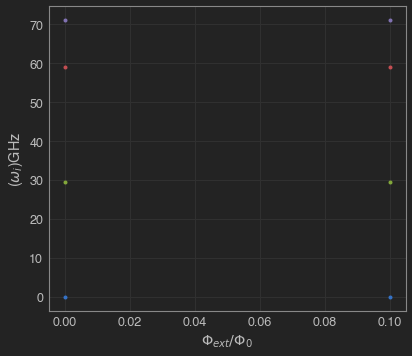

In [138]:
fig = plt.figure()
for i in range(4):
    plt.plot(phiExt/2/np.pi,cr1.HamilEig[i,:].real/GHz-np.min(cr1.HamilEig[0,:]).real/GHz,'.',\
            markersize = 8)
plt.xlabel("$\Phi_{ext}/\Phi_0$")
plt.ylabel("($\omega_i$)GHz")
# plt.savefig("fig1")

## Circuit Hamiltonian
In this section, I diogonalize the circuit Hamiltonian without using the Qcircuit Class. The corrected version of the Hamiltonian of the paper is:

\begin{equation}
\begin{aligned}
H &=H_{O}+H_{C}+H_{\mathrm{int}} \\
H_{\mathrm{O}} &=\hbar \omega_{1} a_{1}^{\dagger} a_{1}+\hbar \omega_{2} a_{2}^{\dagger} a_{2}-\frac{\hbar}{2 \sqrt{Z_{1} Z_{2}}} \tilde{c}_{12}^{-1}\left(a_{1}-a_{1}^{\dagger}\right)\left(a_{2}-a_{2}^{\dagger}\right)-\frac{E_{J 12}}{2}\left(e^{i \phi_{\mathrm{var}}} D_{1}^{\dagger}\left(\alpha_{1}\right) D_{2}^{\dagger}\left(-\alpha_{2}\right)+\mathrm{h.c.}\right) \\
H_{\mathrm{C}} &=\frac{1}{2} \tilde{c}_{33}^{-1} \tilde{Q}_{3}^{2} \\
H_{\mathrm{int}} &=-i \sqrt{\frac{\hbar}{2 Z_{1}}} \tilde{c}_{13}^{-1}\left(a_{1}-a_{1}^{\dagger}\right) \tilde{Q}_{3}-i \sqrt{\frac{\hbar}{2 Z_{2}}} \tilde{c}_{23}^{-1}\left(a_{2}-a_{2}^{\dagger}\right) \tilde{Q}_{3}-\frac{E_{122}}{2}\left(e^{-i \phi_{\mathrm{ix}}} D_{2}^{\dagger}\left(\alpha_{2}\right) d_{3}^{-}+\mathrm{h.c.}\right) \\
&-\frac{E_{\mathrm{J} 33}}{2}\left(D_{1}^{\dagger}\left(\alpha_{1}\right) D_{2}^{\dagger}\left(\alpha_{2}\right) d_{3}^{-}+\mathrm{h.c.}\right)
\end{aligned}
\end{equation}


In [139]:
R = np.array([[1,0,1],[0,1,1],[1,1,1]])
RInv = np.linalg.inv(R)
Cx = cr1.giveMatC()
Lx = cr1.giveMatL()
_ ,S = np.linalg.eig(Lx)
lRotated = R @ Lx @ R 
cInvRotated = RInv @ np.linalg.inv(Cx) @ RInv
print("1st frequency:", np.sqrt(lRotated[0,0]*cInvRotated[0,0])/GHz)
print("2nd frequency:", np.sqrt(lRotated[1,1]*cInvRotated[1,1])/GHz)
print("3rd frequency:", 4*cInvRotated[2,2]*e**2/GHz/hbar)
# print(cr1.JJEqRotated)
# print(cr1.JJEq@R)
Z1 = np.sqrt(cInvRotated[0,0]/lRotated[0,0])
Z2 = np.sqrt(cInvRotated[1,1]/lRotated[1,1])
omega = np.sqrt(np.diag(cInvRotated)*np.diag(lRotated))

print(S.T @ np.linalg.inv(Cx) @ S)
print(cr1.cInvRotated)
print(cr1.omega/GHz)
alpha1 = 1j*2*np.pi/Phi0*np.sqrt(hbar*Z1/2)
alpha2 = 1j*2*np.pi/Phi0*np.sqrt(hbar*Z2/2)
print(alpha1,alpha2)

1st frequency: 71.17323277860973
2nd frequency: 29.58065928330362
3rd frequency: 5.481868369201006
[[ 7.95238698e+12 -5.31404281e+12 -4.03473884e+12]
 [-5.31404281e+12  1.18741408e+13 -2.02490060e+12]
 [-4.03473884e+12 -2.02490060e+12  4.10885805e+13]]
[[ 7.95238698e+12 -5.31404281e+12 -2.32945755e+12]
 [-5.31404281e+12  1.18741408e+13 -1.16907690e+12]
 [-4.03473884e+12 -2.02490060e+12  1.36961935e+13]]
[67.46265936 37.27511314  0.        ]
0.1461403925928947j 0.16282277588255015j


In [140]:
m = 15
def Hamil(phi):
    I = q.qeye(m);
    num = q.num(m);
    charge = q.charge((m-1)/2)
    d = cr1.chargeDisp(m)
    intr = q.destroy(m) - q.create(m)
    
    HLC = omega[0]*q.tensor(num,I,I) +\
    omega[1]*q.tensor(I,num,I) +\
    0.5*(2*e)**2*cInvRotated[2,2]/hbar*q.tensor(I,I,charge)*q.tensor(I,I,charge)-\
    1/np.sqrt(Z1*Z2)/2*cInvRotated[0,1]*q.tensor(intr,intr,I) -\
    1j*np.sqrt(1/(2*hbar*Z1))*(2*e)*cInvRotated[0,2]*q.tensor(intr,I,charge) -\
    1j*np.sqrt(1/(2*hbar*Z2))*(2*e)*cInvRotated[1,2]*q.tensor(I,intr,charge)
    
    alpha1 = 1j*2*np.pi/Phi0*np.sqrt(hbar*Z1/2)
    alpha2 = 1j*2*np.pi/Phi0*np.sqrt(hbar*Z2/2)
    
    HJ12 = JJ[4]/2*np.exp(1j*phi)*q.tensor(q.displace(m,alpha1),q.displace(m,-alpha2),I)
    HJ22 = JJ[1]/2*q.tensor(I,q.displace(m,alpha2),d);
    HJ33 = JJ[3]/2*q.tensor(q.displace(m,alpha1),q.displace(m,alpha2),d)
    
    H = HLC +  HJ12+HJ12.dag() + HJ22+HJ22.dag() + HJ33+HJ33.dag()
    return H

In [141]:
HamilEig = np.zeros((m**3,len(phiExt)),dtype='complex');
for i in range(len(phiExt)):
    print(i)
    if(i==1):
        continue
    H = Hamil(phiExt[i]);
    eigenValues , eigenVectors = H.eigenstates();
    HamilEig[:,i] = eigenValues

0
1


In [142]:
for i in range(10):
    print(HamilEig[i,0].real/GHz-HamilEig[0,0].real/GHz)

0.0
29.435985250747763
58.87197308454779
71.0611565685831
88.30794449945097
100.4971467134601
117.74351785349427
129.93313944002148
142.12231501869974
147.1736961072893


Text(0, 0.5, '($\\omega_i$)GHz')

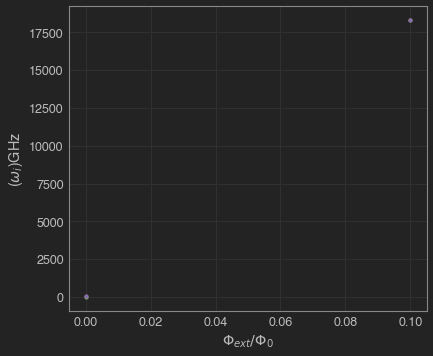

In [133]:
plt.figure()
for i in range(4):
    plt.plot(phiExt/2/np.pi,HamilEig[i,:].real/GHz-np.min(HamilEig[0,:]).real/GHz,'.',\
            markersize = 8)
plt.xlabel("$\Phi_{ext}/\Phi_0$")
plt.ylabel("($\omega_i$)GHz")
# plt.savefig("fig2")

## JJ part of the Hamiltonian
In this part I want to study the $E_{J12}$ part of the Hamiltonian individually
$$
H_{J12} = -\frac{E_{J12}}{2}\left(D_{1}^{\dagger}\left(\alpha_{1}\right) D_{2}^{\dagger}\left(\alpha_{2}\right)+\mathrm{h.c.}\right)
$$


In [109]:
R = np.array([[1,0,1],[0,1,1],[1,1,1]])
RInv = np.linalg.inv(R)
Cx = cr1.giveMatC()
Lx = cr1.giveMatL()
lRotated = R @ Lx @ R 
cInvRotated = RInv @ np.linalg.inv(Cx) @ RInv
Z1 = np.sqrt(cInvRotated[0,0]/lRotated[0,0])
Z2 = np.sqrt(cInvRotated[1,1]/lRotated[1,1])
alpha1 = 1j*2*np.pi/Phi0*np.sqrt(hbar*Z1/2)
alpha2 = 1j*2*np.pi/Phi0*np.sqrt(hbar*Z2/2)
phi = 0

def Hamil_JJ12(m):
    print(m)
    H = -JJ[4]/2*np.exp(1j*phi)*q.tensor(q.displace(m[0],alpha1),q.displace(m[1],-alpha2),q.qeye(m[2]))
    H = H + H.dag()
    print(JJ[4])
    return H

def eigH_JJ12(m,j):
    numEig=3
    HamilEig = np.zeros((numEig,len(m[j])),dtype='complex');
    for i0 in range(len(m[j])):
        mList= [];
        for i1 in range(len(m)):
            if(i1==j):
                mList.append(int(m[i1][i0])) 
            else:
                mList.append(m[i1])
        H = Hamil_JJ12(mList)
        eigenValues , eigenVectors = H.eigenstates();
        HamilEig[:,i0] = eigenValues[0:numEig]
    return HamilEig

In [137]:
m = [np.linspace(8,19,12),17,21]
HamilEig = eigH_JJ12(m,0)

[8, 17, 21]
[9, 17, 21]
[10, 17, 21]
[11, 17, 21]
[12, 17, 21]
[13, 17, 21]
[14, 17, 21]
[15, 17, 21]
[16, 17, 21]
[17, 17, 21]
[18, 17, 21]
[19, 17, 21]


Text(0, 0.5, '($\\omega_i$)GHz')

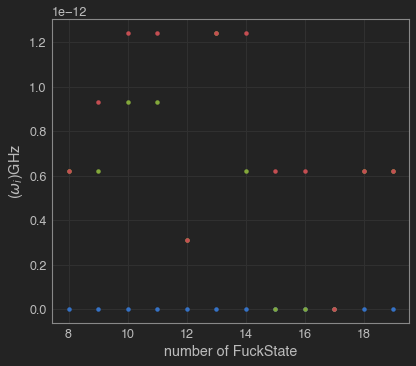

In [138]:
plt.figure()
for i in range(3):
    plt.plot(m[0],(HamilEig[i,:]-HamilEig[0,:]).real/GHz,'.',markersize=9)
plt.xlabel("number of FuckState")
plt.ylabel("($\omega_i$)GHz")

In [83]:
H = Hamil_JJ12([10,10,10])
I0, J0 = H.data.shape
x = np.zeros(H.data.shape, dtype= "complex")
for i in range(I0):
    x[i,i] = H.data[i,i]
# eigVal , eigState = np.linalg.eig(x)
# print(eigVal)
eigVal , eigState = H.eigenstates()
# print(eigVal)

[10, 10, 10]
9801769079200.154
